# Ma/Jamieson Treated Mouse Samples RNA-Seq Analysis
</div>


## Parameter Input

In [1]:
gPreviousStepRdataFp = "../interim/crews_serialtransplant_rnaseq_20220428_data.RData"

In [2]:
gSourceDir = "./src/"
# Import shared source code to load and save previous notebooks' environments:
source(paste0(gSourceDir, "ChainedNotebookSupport.R"))
# Import the previous step's state:
gPreviousStepEnv = loadToEnvironment(gPreviousStepRdataFp)

In [3]:
# Load relevant variables:
gDgeList = gPreviousStepEnv$gDgeList
gIsoDgeList = gPreviousStepEnv$gIsoDgeList
gGeneType = gPreviousStepEnv$gGeneType
gGeneIdCol = gPreviousStepEnv$gGeneIdCol
gIsoIdCol = gPreviousStepEnv$gIsoIdCol

[Table of Contents](#Table-of-Contents)

## Library Import

Import the necessary R, Bioconductor, and CCBB libraries for the analysis:

In [4]:
library(limma)
library(edgeR)
library(Glimma)
library(ggpubr)

Loading required package: ggplot2



In [5]:
library(IRdisplay)

Warning message:
“package ‘IRdisplay’ was built under R version 4.1.0”


In [6]:
source(paste0(gSourceDir, "PcaPlotter.R"))
source(paste0(gSourceDir, "CountsPcaPlotter.R"))


Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend




In [7]:
# This line prevents SVG output, which interacts badly with export to HTML
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))
options(browser = 'firefox')

[Table of Contents](#Table-of-Contents)

## Data Exploration

### Library Size Visualization

Examine the characteristics of the raw reads for protein coding genes:

### Removal of Low-Alignment Samples

In [8]:
gSamplesToKeepMask = gDgeList$samples$lib.size > 10000000 # 10 million aligned reads
length(gDgeList$samples$lib.size)
sum(gSamplesToKeepMask==TRUE)

[1] 13

[1] 11

In [9]:
gSampleFilteredDgeList = gDgeList[,gSamplesToKeepMask]
dim(gSampleFilteredDgeList)
gSampleFilteredIsoDgeList = gIsoDgeList[,gSamplesToKeepMask]
dim(gSampleFilteredIsoDgeList)

[1] 19937    11

[1] 161790     11

[Table of Contents](#Table-of-Contents)

## Pre-Processing

### Scale Transformation and Lowly-Expressed Genes Filtration

> For differential expression and related analyses, gene expression is rarely considered at the level of raw counts since libraries sequenced at a greater depth will result in higher counts. Rather, it is common practice to transform raw counts onto a scale that accounts for such library size differences. Popular transformations include counts per million (CPM), log2-counts per million (log-CPM), reads per kilobase of transcript per million (RPKM), and fragments per kilobase of transcript per million (FPKM).
>
> In our analyses, CPM and log-CPM transformations are used regularly although they do not account for feature length differences which RPKM and FPKM values do. Whilst RPKM and FPKM values can just as well be used, CPM and log-CPM values can be calculated using a counts matrix alone and will suffice for the type of comparisons we are interested in. Assuming that there are no differences in isoform usage between conditions, differential expression analyses look at gene expression changes between conditions rather than comparing expression across multiple genes or drawing conclusions on absolute levels of expression. In other words, gene lengths remain constant for comparisons of interest and any observed differences are a result of changes in condition rather than changes in gene length.
>
> Here raw counts are converted to CPM and log-CPM values using the cpm function in edgeR, where log-transformations use a prior count of 0.25 to avoid taking the log of zero. RPKM values are just as easily calculated as CPM values using the rpkm function in edgeR if gene lengths are available. ([1](#Citations))

Also, regarding lowly expressed genes:

> All datasets will include a mix of genes that are expressed and those that are not expressed. Whilst it is of interest to examine genes that are expressed in one condition but not in another, some genes are unexpressed throughout all samples....
>
> Genes that are not expressed at a biologically meaningful level in any condition should be discarded to reduce the subset of genes to those that are of interest, and to reduce the number of tests carried out downstream when looking at differential expression. Upon examination of log-CPM values, it can be seen that a large proportion of genes within each sample is unexpressed or lowly-expressed .... Using a nominal CPM value of 1 (which is equivalent to a log-CPM value of 0) genes are deemed to be expressed if their expression is above this threshold, and unexpressed otherwise. Genes must be expressed in at least one group (or in at least [a minimum number of] samples across the entire experiment) to be kept for downstream analysis.
>
> Although any sensible value can be used as the expression cutoff, typically a CPM value of 1 is used in our analyses as it separates expressed genes from unexpressed genes well for most datasets. ... If sequence reads are summarised by exons rather than genes and/or experiments have low sequencing depth, a lower CPM cutoff may be considered. ([1](#Citations))

A filtration threshold of 1 CPM (counts per million) means a gene is considered expressed if it has more than the below number of counts in the sample with the lowest sequencing depth:

In [10]:
# NB: this must be re-selected each time a new analysis is run
# to ensure these values are appropriate to the data
gMinExclusiveCpms = 1
gMinInclusiveNumSamples = 3 

In [11]:
filterDgeListByCpmThresholdForNumSamples = function(aDgeList, minExclusiveCpms, minInclusiveNumSamples){
    cpmsMatrix = cpm(aDgeList)
    keepMask = rowSums(cpmsMatrix>minExclusiveCpms)>=minInclusiveNumSamples
    filteredDgeList = aDgeList[keepMask,, keep.lib.sizes=FALSE]
    return(filteredDgeList)
}


In [12]:
gFilteredIsoDgeList = filterDgeListByCpmThresholdForNumSamples(gSampleFilteredIsoDgeList, gMinExclusiveCpms, gMinInclusiveNumSamples)

In [13]:
lcpm2_iso <- cpm(gFilteredIsoDgeList, log=TRUE)

In [14]:
library(ggpubr)
library(reshape2)

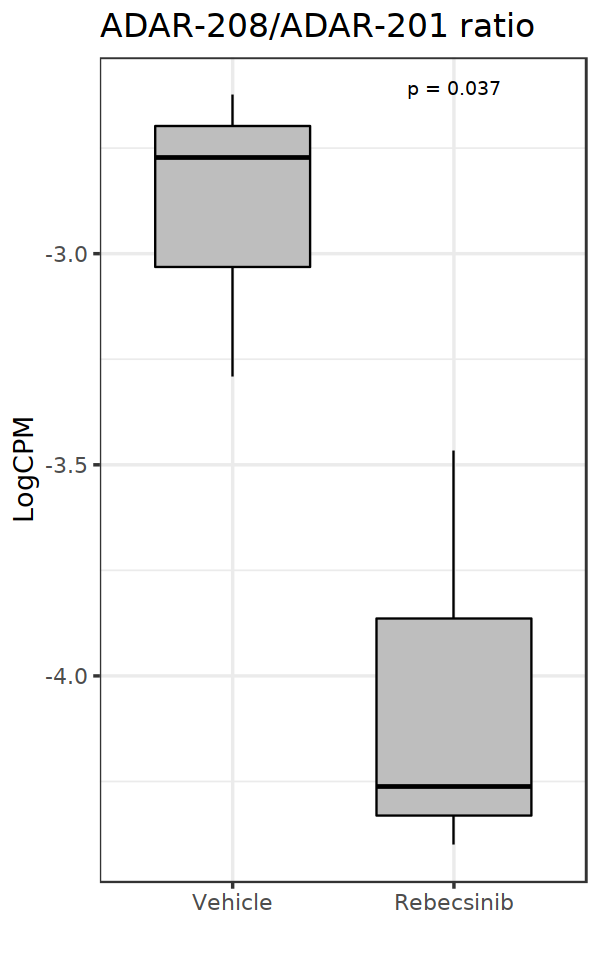

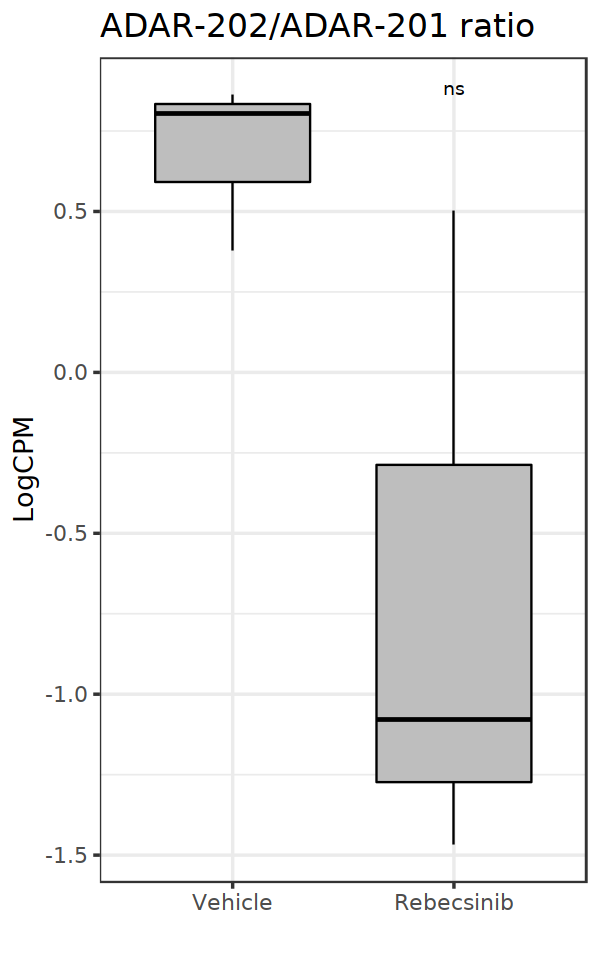

In [15]:
ADAR.ratio.tx.exp <- c("ENST00000368471", "ENST00000368474", "ENST00000529168", "ENST00000368474_2")
ADAR.ratio.tx.exp.lcpm <- lcpm2_iso[rownames(lcpm2_iso) %in% ADAR.ratio.tx.exp,]
ADAR.ratio.tx.exp.df <- cbind.data.frame(gIsoDgeList$samples[rownames(gIsoDgeList$samples) %in% colnames(ADAR.ratio.tx.exp.lcpm),], 
                                   as.data.frame(t(ADAR.ratio.tx.exp.lcpm)))
colnames(ADAR.ratio.tx.exp.df)[8:11] <- c("ADAR_201", "ADAR_202", "ADAR_208", "ADARp150_2")
ADAR.ratio.tx.exp.df$ADARp150_comb <- apply(ADAR.ratio.tx.exp.df, 1, function(x) mean
                                            (as.numeric(x[9:10])))
ADAR.ratio.tx.exp.df$Ratio <- ADAR.ratio.tx.exp.df$ADAR_202 - ADAR.ratio.tx.exp.df$ADAR_201
ADAR.ratio.tx.exp.df$Ratio2 <- ADAR.ratio.tx.exp.df$ADAR_208 - ADAR.ratio.tx.exp.df$ADAR_201
ADAR.ratio.tx.exp.df$Ratio3 <- ADAR.ratio.tx.exp.df$ADARp150_comb - ADAR.ratio.tx.exp.df$ADAR_201
ADAR.ratio.tx.exp.df$Ratio4 <- ADAR.ratio.tx.exp.df$ADARp150_2 - ADAR.ratio.tx.exp.df$ADAR_201
ADAR.ratio.tx.exp.df <- subset(ADAR.ratio.tx.exp.df, group == "V" | group == "S")
ADAR.ratio.tx.exp.df$Tx <- factor(ADAR.ratio.tx.exp.df$Tx, levels=c("V", "S", "C"))
ADAR.ratio.tx.exp.df$Treatment <- "Vehicle"
ADAR.ratio.tx.exp.df$Treatment[which(ADAR.ratio.tx.exp.df$Tx %in% "S")] <- "Rebecsinib"
ADAR.ratio.tx.exp.df$Treatment <- factor(ADAR.ratio.tx.exp.df$Treatment, levels=c("Vehicle", "Rebecsinib"))                                 

options(repr.plot.width=5, repr.plot.height=8)
ggboxplot(subset(ADAR.ratio.tx.exp.df, Tx != "F"), x="Treatment", y="Ratio2", ylab="LogCPM", fill="Gray",
          xlab="", main="ADAR-208/ADAR-201 ratio",) + theme_bw(base_size=16) + 
          stat_compare_means(ref.group = "Vehicle",method = "t.test", label="p.format")

options(repr.plot.width=5, repr.plot.height=8)
ggboxplot(subset(ADAR.ratio.tx.exp.df, Tx != "F"), x="Treatment", y="Ratio4", ylab="LogCPM", fill="Gray",
          xlab="", main="ADAR-202/ADAR-201 ratio",) + theme_bw(base_size=16) + 
          stat_compare_means(ref.group = "Vehicle",method = "t.test", label="p.signif")


## Appendix: R Session Info

In [16]:
Sys.time()
sessionInfo()

[1] "2023-01-19 22:19:30 UTC"

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/ubuntu/anaconda3/lib/libmkl_rt.so.1

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] reshape2_1.4.4 cowplot_1.1.1  IRdisplay_1.0  ggpubr_0.4.0   ggplot2_3.3.5 
[6] Glimma_2.0.0   edgeR_3.32.1   limma_3.46.0  

loaded via a namespace (and not attached):
 [1] bitops_1.0-7                matrixStats_0.61.0         
 [3] bit64_4.0.5                 RColorBrewer_1.1-2         
 [5] httr_1.4.2                  GenomeInfoDb_1.26.7        
 [7] repr_1.1.3

[Table of Contents](#Table-of-Contents)

Copyright (c) 2018 UC San Diego Center for Computational Biology & Bioinformatics under the MIT License

Notebook template by Amanda Birmingham